In [76]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [77]:
df = pd.read_csv("pokemon_data.csv", index_col = "Name")


In [78]:
if 'Smash Normalized' not in df.columns:
    df['Smash Scaled'] = (df['Smashes'] - df['Smashes'].min()) / (df['Smashes'].max() - df['Smashes'].min())
    df['Pass Scaled'] = (df['Passes'] - df['Passes'].min()) / (df['Passes'].max() - df['Passes'].min())
    df['Total'] = df['Smash Scaled'] + df['Pass Scaled']
    df['Smash Normalized'] = (df['Smash Scaled'] / df['Total']) * 10

# Save the updated CSV
df[['Passes','Smashes','Smash Normalized']].to_csv("your_file.csv")

In [79]:
df.head()

,Passes,Smashes,Smash Normalized
Name,,,
Bulbasaur,1187934.0,331851.0,2.900818
Ivysaur,1172763.0,303853.0,2.746478
Venusaur,1175757.0,273495.0,2.534232
Charmander,1152826.0,271930.0,2.561130
Charmeleon,1135715.0,275524.0,2.615797


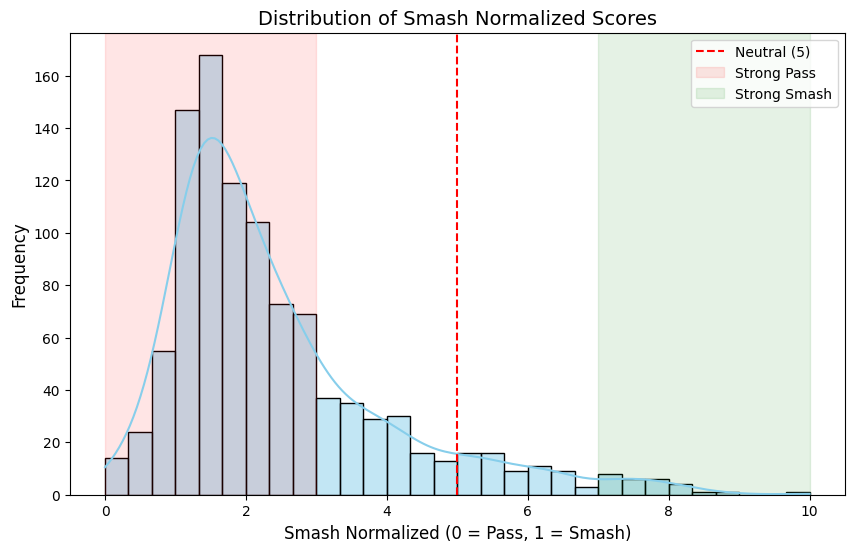

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.histplot(df['Smash Normalized'], kde=True, bins=30, color='skyblue', edgecolor='black')

# Highlight key regions
ax.axvline(5, color='red', linestyle='--', label='Neutral (5)')
ax.axvspan(0, 3, color='red', alpha=0.1, label='Strong Pass')
ax.axvspan(7, 10, color='green', alpha=0.1, label='Strong Smash')

plt.title("Distribution of Smash Normalized Scores", fontsize=14)
plt.xlabel("Smash Normalized (0 = Pass, 1 = Smash)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

## Dataset and Preprocessing

In [81]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd

class SmashDataset(Dataset):
    def __init__(self, image_dir, paths, labels, augment_flags):
        self.image_dir = image_dir
        self.paths = paths
        self.labels = labels  # Correctly store the labels
        self.augment_flags = augment_flags  # Store augment flags in the correct variable
        
        self.basic_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
        self.augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def remove_alpha(self, image):
        if image.mode == 'RGBA':
            background = Image.new("RGB", image.size, (255, 255, 255))
            background.paste(image, mask=image.split()[3])  # 3 is alpha channel
            return background
        else:
            return image.convert("RGB")

    def __getitem__(self, idx):
        path = os.path.join(self.image_dir, self.paths[idx])
        image = Image.open(path)
        image = self.remove_alpha(image)

        label = self.labels[idx].astype(np.float32)
        
        # Use augment_flags to determine if augmentation is needed
        if self.augment_flags[idx]:
            image = self.augment_transform(image)
        else:
            image = self.basic_transform(image)

        return image, label

    def __len__(self):
        return len(self.paths)



# Oversampling

In [ ]:
# Step 1: Label buckets (before split)
from sklearn.model_selection import train_test_split

# Step 1: Bucketing
low_mask = df['Smash Normalized'] <= 4.0
mid_mask = (df['Smash Normalized'] > 4.0) & (df['Smash Normalized'] <= 7.0)
high_mask = df['Smash Normalized'] > 7.0

df['bucket'] = np.select([low_mask, mid_mask, high_mask], ['low', 'mid', 'high'])
df['augment_flags'] = False  # default to False

# Step 2: Split before oversampling
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['bucket'])

# Step 3: Apply oversampling only on training data
low_df = train_df[train_df['bucket'] == 'low']
mid_df = train_df[train_df['bucket'] == 'mid']
high_df = train_df[train_df['bucket'] == 'high']

target_count = max(len(low_df), len(mid_df))
target_count_small = min(len(low_df), len(mid_df))


oversampled_mid = mid_df.sample(n=target_count, replace=True, random_state=42)
oversampled_high = high_df.sample(n=target_count, replace=True, random_state=42)

# oversampled_mid['augment_flags'] = True
oversampled_high['augment_flags'] = True

resampled_train_df = pd.concat([low_df, oversampled_mid, oversampled_high])
resampled_train_df = resampled_train_df.sample(frac=1.0, ranDDdom_state=42)

#  Reset index so 'Name' becomes a column
df = df.reset_index()
resampled_train_df = resampled_train_df.reset_index()
val_df = val_df.reset_index()

# Step 4: Set up datasets
train_dataset = SmashDataset(
    "images",
    resampled_train_df['Name'].astype(str) + '.png',
    resampled_train_df['Smash Normalized'].values.astype(np.float32),
    resampled_train_df['augment_flags'].values
)

val_dataset = SmashDataset(
    "images",
    val_df['Name'].astype(str) + '.png',
    val_df['Smash Normalized'].values.astype(np.float32),
    val_df['augment_flags'].values
)

# Step 5: DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)



C:\Users\user\AppData\Local\Temp\ipykernel_16528\705894463.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_df['augment_flags'] = False


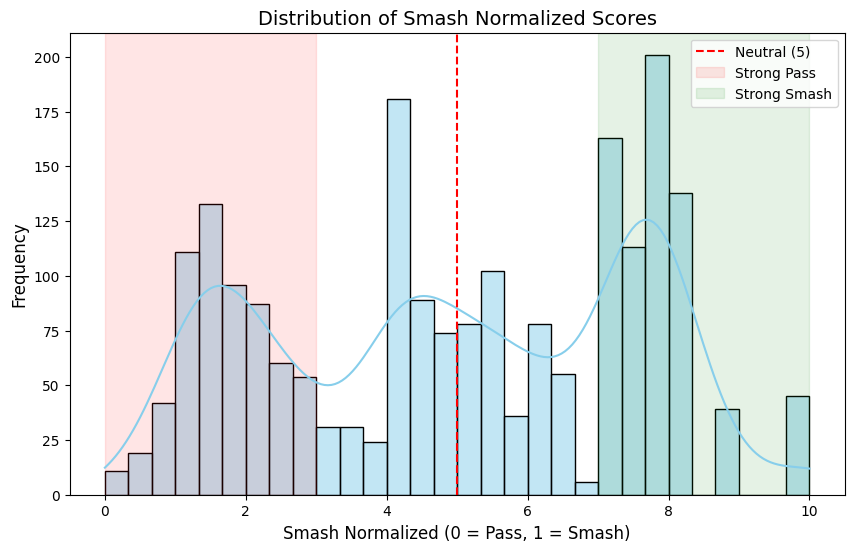

In [83]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(resampled_train_df['Smash Normalized'], kde=True, bins=30, color='skyblue', edgecolor='black')

# Highlight key regions
ax.axvline(5, color='red', linestyle='--', label='Neutral (5)')
ax.axvspan(0, 3, color='red', alpha=0.1, label='Strong Pass')
ax.axvspan(7, 10, color='green', alpha=0.1, label='Strong Smash')

plt.title("Distribution of Smash Normalized Scores", fontsize=14)
plt.xlabel("Smash Normalized (0 = Pass, 1 = Smash)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

# Training

## Model

In [84]:
import torch.nn as nn

class SmashRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = base_model.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = True
        
        self.regressor = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1280, 512),
        
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 256),
        
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 64),
        
        nn.ReLU(),
        nn.Linear(64, 1)
)


    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.pool(x)
        x = self.regressor(x)
        return x.squeeze(1)


## Training Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmashRegressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.9, patience=3, verbose=True
)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)




def weighted_huber_loss(y_pred, y_true, delta=2.0):
    error = y_true - y_pred
    weights = 1.0 + 0.5 * y_true
    abs_error = torch.abs(error)
    condition = abs_error < delta
    loss = torch.where(condition, 0.5 * error ** 2, delta * (abs_error - 0.5 * delta))
    return torch.mean(weights * loss)

def custom_accuracy(y_pred, y_true):
    return ((torch.abs(y_pred - y_true) < 0.5).float().mean()).item()


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Training Loop

In [86]:
from tqdm import tqdm

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

criterion = nn.MSELoss()

best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(25):
    model.train()
    train_losses, train_accs = [], []

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = weighted_huber_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(custom_accuracy(outputs, labels))

    model.eval()
    val_losses, val_accs = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_losses.append(weighted_huber_loss(outputs, labels).item())
            val_accs.append(custom_accuracy(outputs, labels))

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    train_acc = np.mean(train_accs)
    val_acc = np.mean(val_accs)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    scheduler.step(val_loss)


100%|██████████| 33/33 [00:25<00:00,  1.32it/s]


Early stopping triggered


## Plotting

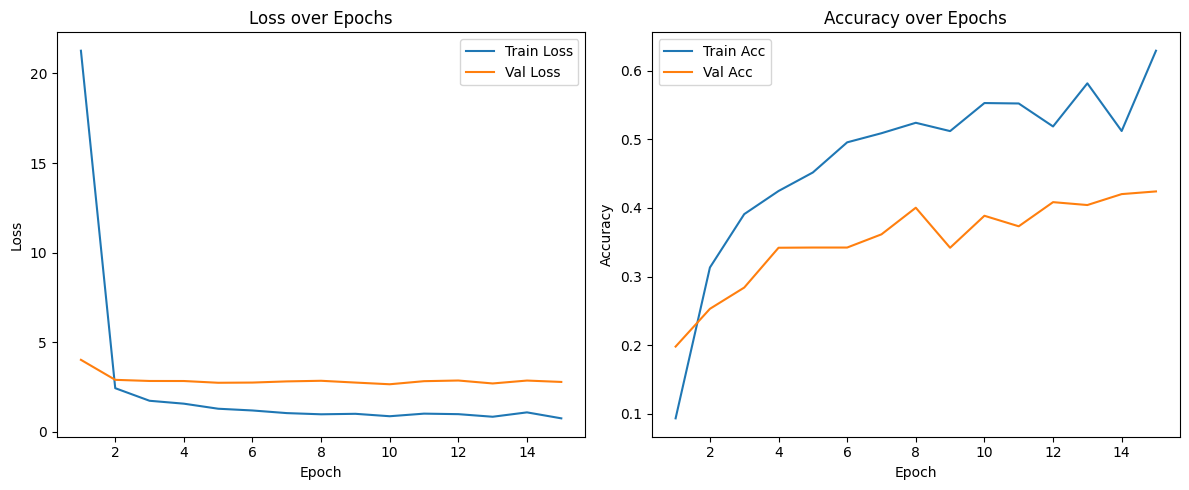

In [87]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, label='Train Acc')
plt.plot(epochs, val_acc_history, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [88]:
from PIL import Image
from torchvision import transforms

# Same preprocessing as training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to [0, 1]
])

def predict_image(path):
    image = Image.open(path).convert('RGBA')
    
    # If image has alpha channel, blend it with white
    if image.mode == 'RGBA':
        background = Image.new("RGB", image.size, (255, 255, 255))
        background.paste(image, mask=image.split()[3])  # Alpha channel
        image = background
    else:
        image = image.convert("RGB")

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim
    
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        prediction = model(image_tensor)
        return prediction.item()

In [89]:
score = predict_image("leaf.jpg")
print(f"Smash score (0–10 scale): {score:.2f}")
# print(resampled_df.loc["Greninja"]['Smash Normalized'])


FileNotFoundError: [Errno 2] No such file or directory: 'leaf.jpg'